In [3]:
%matplotlib inline

In [4]:
# global params
trained =  True # loads models with random weight and not pretrained weights
case = 'unnormalized'
only_tune_last_layer = True
train_models = True
# epochs = 10 # for Bees and 6 for CIFAR
which_db = 'CIFAR10'

num_data = 10000 if which_db=='Bees' else 1000
epochs = 10 if which_db=='Bees' else 6

In [5]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode


import torchvision.transforms as transforms

!pip install timm


from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 5.7 MB/s 
     |████████████████████████████████| 163 kB 52.4 MB/s 


In [6]:
if which_db=='Bees':
  !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
  !mkdir data
  !unzip hymenoptera_data.zip
  !mv hymenoptera_data ./data

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [7]:
if which_db=='Bees':
  # Data augmentation and normalization for training
  # Just normalization for validation
  data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'val': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }

  data_dir = 'data/hymenoptera_data'
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                            data_transforms[x])
                    for x in ['train', 'val']}
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
                for x in ['train', 'val']}
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  class_names = image_datasets['train'].classes

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
if which_db=='CIFAR10':

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  ds = 'cifar10'

  mean = {
  'cifar10': (0.4914, 0.4822, 0.4465),
  'cifar100': (0.5071, 0.4867, 0.4408),
  }

  std = {
  'cifar10': (0.2023, 0.1994, 0.2010),
  'cifar100': (0.2675, 0.2565, 0.2761),
  }

  mean, std = mean[ds], std[ds]


  args_batch_size = 256
  args_scale = 1
  args_reprob = 0
  args_ra_m = 12
  args_ra_n = 2
  args_jitter = 0
  res = 32
  num_classes = 10 if ds == 'cifar10' else 100
  args_lr_max = 0.05
  args_wd = 0.005
  args_epochs = 100
  args_clip_norm = True
  args_workers = 2



  train_transform = transforms.Compose([
      # transforms.RandomResizedCrop(32, scale=(args_scale, 1.0), ratio=(1.0, 1.0)),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandAugment(num_ops=args_ra_n, magnitude=args_ra_m),
      transforms.ColorJitter(args_jitter, args_jitter, args_jitter),
      transforms.ToTensor(),
      transforms.Normalize(mean, std),
      transforms.RandomErasing(p=args_reprob)
  ])

  test_transform = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
  ])


  trainset = getattr(torchvision.datasets, ds.upper())(
      root='./data', train=True, download=True, transform=train_transform)
  testset = getattr(torchvision.datasets, ds.upper())(
      root='./data', train=False, download=True, transform=test_transform)
  print('\nNumber of images in the train set:', len(trainset), 
        '; Number of images in the test set:', len(testset))

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=args_batch_size,
                                            shuffle=True, num_workers=args_workers)
  testloader = torch.utils.data.DataLoader(testset, batch_size=args_batch_size,
                                          shuffle=False, num_workers=args_workers)


  class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 


  dataloaders = {}
  dataloaders['train'] = trainloader
  dataloaders['val'] = testloader

  dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Number of images in the train set: 50000 ; Number of images in the test set: 10000


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



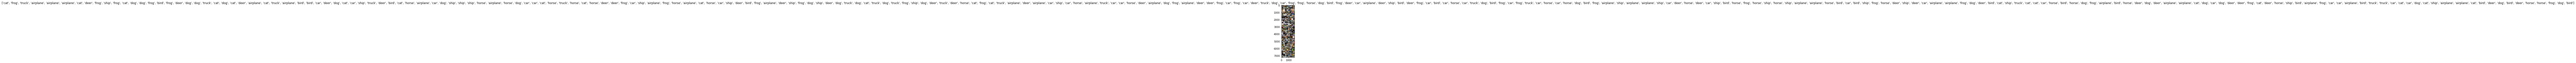

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def eval_model(model):
    phase = 'val'
    model.eval()   # Set model to evaluate mode

    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        with torch.set_grad_enabled(phase == 'train'):
          running_corrects += torch.sum(preds == labels.data)

    epoch_acc = running_corrects.double() / dataset_sizes[phase]


    print(f'val Acc: {epoch_acc:4f}')


### Visualizing the model predictions

Generic function to display predictions for a few images




In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [13]:
# convert all the models to binary classifier
num_classes = 2 if which_db=='Bees' else 10

def prepare_models(models, only_tune_last_layer=True):

  # First set all the requires_grads FALSE
  if only_tune_last_layer: # means only fine tune the last year if set
    for model in models:
      print(model.__class__.__name__)

      for name, param in model.named_parameters():
          param.requires_grad = False

  for model in models:
    print(model.__class__.__name__)

    if model.__class__.__name__.lower() in ['resnet', 'googlenet', 'inception3']:
      print(model.fc.in_features)
      num_ftrs = model.fc.in_features
      model.fc = nn.Linear(num_ftrs, num_classes)

      if only_tune_last_layer:
        for name, param in model.named_parameters():
          if name.startswith('fc'):
            param.requires_grad = True


    elif model.__class__.__name__.lower() == 'densenet':
      print(model.classifier.in_features)
      num_ftrs = model.classifier.in_features
      model.classifier = nn.Linear(num_ftrs, num_classes)

      if only_tune_last_layer:
        for name, param in model.named_parameters():
          if name.startswith('classifier'):
            param.requires_grad = True


    elif model.__class__.__name__.lower() == 'visiontransformer':
      print(model.head.in_features)
      num_ftrs = model.head.in_features
      model.head = nn.Linear(num_ftrs, num_classes)

      if only_tune_last_layer:
        for name, param in model.named_parameters():
          if name.startswith('head'):
            param.requires_grad = True

      
    elif model.__class__.__name__.lower() == 'alexnet':    
      print(model.classifier[-1].in_features)
      num_ftrs = model.classifier[-1].in_features
      model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

      if only_tune_last_layer:
        for name, param in model.named_parameters():
          if name.startswith('classifier.6'):
            param.requires_grad = True


    else:
      print(model.classifier[1].in_features)
      num_ftrs = model.classifier[1].in_features
      model.classifier[1] = nn.Linear(num_ftrs, num_classes)
      if only_tune_last_layer:
        for name, param in model.named_parameters():
          if name.startswith('classifier.1'):
            param.requires_grad = True


    model = model.to(device)

In [14]:

models = [torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=trained, force_reload=True,  skip_validation=True), 
          torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=trained,force_reload=True,  skip_validation=True), 
          torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=trained,force_reload=True,  skip_validation=True), 
          torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=trained,force_reload=True,  skip_validation=True),
          torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=trained,force_reload=True,  skip_validation=True), 
          torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=trained,force_reload=True,  skip_validation=True),
          # torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=trained,force_reload=True,  skip_validation=True), 
          torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=trained,force_reload=True,  skip_validation=True),
          torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl',force_reload=True,  skip_validation=True), 
          torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=trained,force_reload=True,  skip_validation=True)]



Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

Downloading: "https://github.com/facebookresearch/WSL-Images/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [15]:
# for model in models:
#   model.to(device)

In [16]:
prepare_models(models, only_tune_last_layer=only_tune_last_layer)

ResNet
ResNet
AlexNet
DenseNet
GoogLeNet
MobileNetV2
ResNet
ResNet
VisionTransformer
ResNet
2048
ResNet
2048
AlexNet
4096
DenseNet
1024
GoogLeNet
1024
MobileNetV2
1280
ResNet
2048
ResNet
2048
VisionTransformer
768


In [17]:
# eval_model(models[0])

In [18]:
ls

data/  sample_data/


#### load the trained models if you have trained them already



In [20]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/CIFAR10_Models_set2.zip

# loading models
for idx, model in enumerate(models):
  print(idx, model.__class__.__name__)
  # model = torch.load('/content/drive/MyDrive/CIFAR10_Models/model_'+str(idx)+'.pth')
  # model.load_state_dict(torch.load('/content/drive/MyDrive/CIFAR10_Models_set2/model_'+str(idx)+'.pth'))
  model.load_state_dict(torch.load('CIFAR10_Models_set2/model_'+str(idx)+'.pth'))
  # eval_model(model)





Mounted at /content/drive
Archive:  /content/drive/MyDrive/CIFAR10_Models_set2.zip
  inflating: CIFAR10_Models_set2/model_5.pth  
  inflating: CIFAR10_Models_set2/model_4.pth  
  inflating: CIFAR10_Models_set2/model_3.pth  
  inflating: CIFAR10_Models_set2/model_6.pth  
  inflating: CIFAR10_Models_set2/model_0.pth  
  inflating: CIFAR10_Models_set2/model_8.pth  
  inflating: CIFAR10_Models_set2/model_2.pth  
  inflating: CIFAR10_Models_set2/model_7.pth  
  inflating: CIFAR10_Models_set2/model_1.pth  
0 ResNet
1 ResNet
2 AlexNet
3 DenseNet
4 GoogLeNet
5 MobileNetV2
6 ResNet
7 ResNet
8 VisionTransformer


In [ ]:
# # dir(param)
# for p in models[0].parameters():
#     if p.requires_grad:
#          print(p.name, p.data)

In [ ]:
# for model in models[4:5]:
#   print(model.__class__.__name__)

#   for name, param in model.named_parameters():
#       # if 'fc' in name:
#         # param.requires_grad = True
#         print(name, param.requires_grad)      


# Train models

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
# if train_models: # models should be trained

#   # dir(models[0])
#   from google.colab import drive
#   drive.mount('/content/drive')

#   !mkdir /content/drive/MyDrive/CIFAR10_Models

#   criterion = nn.CrossEntropyLoss()

#   for idx, model in enumerate(models):
    
#     # Observe that all parameters are being optimized
#     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#     # Decay LR by a factor of 0.1 every 7 epochs
#     exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  

#     # print(
#     print(model.__class__.__name__)
#     model = train_model(model, criterion, optimizer, exp_lr_scheduler,
#                         num_epochs=epochs)
    
#     torch.save(model.state_dict(), '/content/drive/MyDrive/CIFAR10_Models/model_'+str(idx)+'.pth')

Mounted at /content/drive
ResNet
Epoch 0/5
----------


#### save models if you want[link text](https://)

In [ ]:
# # dir(models[0])
# from google.colab import drive
# drive.mount('/content/drive')

# # !mkdir /content/drive/MyDrive/CIFAR10_Models

# # saving models
# for idx, model in enumerate(models[:1]):
#   print(idx)
#   # torch.save(model, '/content/drive/MyDrive/CIFAR10_Models/model_'+str(idx)+'.pth')
#   torch.save(model.state_dict(), '/content/drive/MyDrive/CIFAR10_Models/model_'+str(idx)+'.pth')


# Extract logits

In [21]:
# extract features over training data 
def extract_features(model, num_datapoints=100, case='normalized'):
    X_train, X_val = torch.empty(1,num_classes, dtype=torch.float16), torch.empty(1,num_classes,dtype=torch.float16)
    model.eval()   # Set model to evaluate mode

    with torch.no_grad():
      for phase in ['train', 'val']:

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                outputs = model(inputs).cpu() # logits which should be saved
                # breakpoint()
                if case == 'normalized':
                    outputs = outputs/outputs.sum(axis=1)[:,None]

                
                # print(outputs.shape)
                # _, preds = torch.max(outputs, 1)
                
                if phase == 'train':
                  X_train = torch.vstack((X_train,outputs))
                  if X_train.shape[0] > num_datapoints: break
                else:
                  X_val = torch.vstack((X_val,outputs))
                  if X_val.shape[0] > num_datapoints: break                  

    return X_train[1:num_datapoints], X_val[1:num_datapoints]


In [ ]:
# X[0]

In [ ]:
# X[-1]

In [35]:
# num_classes = 1000 # only for imageNet

X, X_val = torch.empty(1,num_classes, dtype=torch.float16), torch.empty(1,num_classes,dtype=torch.float16)
y, y_val = [], []

num_datapoints = num_data
case = 'unnormalized'

for idx, model in enumerate(models):
  print(model.__class__.__name__)
  train_ft, val_ft = extract_features(model, num_datapoints, case)  
  X = torch.vstack((X,train_ft))
  X_val = torch.vstack((X_val,val_ft))

  y.extend([idx]*train_ft.shape[0]) 
  y_val.extend([idx]*val_ft.shape[0]) 


X = X[1:]
X_val = X_val[1:]

y = torch.tensor(y)
y_val = torch.tensor(y_val)

idx_t = torch.randperm(X.shape[0])
X = X[idx_t]
y = y[idx_t]

idx_v = torch.randperm(X_val.shape[0])
X_val = X_val[idx_v]
y_val = y_val[idx_v]


print(X.shape, X_val.shape) #, train_ft2.shape, val_ft2.shape)
print(y.shape, y_val.shape) #, train_ft2.shape, val_ft2.shape)

ResNet
ResNet
AlexNet
DenseNet
GoogLeNet
MobileNetV2
ResNet
ResNet
VisionTransformer
torch.Size([8991, 10]) torch.Size([8991, 10])
torch.Size([8991]) torch.Size([8991])


# Train a classifier on logits 

In [36]:
# multi class
#Importing the necessary packages and libaries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import numpy as np


In [43]:
# swap variables
X, X_new = X_new, X
y, y_new =  y_new, y
X_val, X_val_new = X_val_new, X_new
y_val, y_val_new =  y_val_new, y_val

In [44]:
num_trains = [10, 100, 500, 1000, 2000]

for num_train in num_trains:
  model_svm = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X[:num_train], y[:num_train])
  model_rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X[:num_train], y[:num_train])
  # model = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X, y)
  # model = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X, y)

  # print()
  for m in [model_svm, model_rbf]:
  # for m in [model_svm]:
  # for m in [model_rbf]:  
    pred = m.predict(X_val)
    accuracy = m.score(X_val, y_val)
    print(f'{num_train}: {accuracy}')
    
    # cm = confusion_matrix(y_val, pred)

    # print(cm)

    # plt.imshow(cm)
    # plt.show()

10: 0.12012012012012012
10: 0.1111111111111111
100: 0.1612723834946057
100: 0.1206762317873429
500: 0.19130241352463576
500: 0.1578244911578245
1000: 0.20831943054165275
1000: 0.17217217217217218
2000: 0.2222222222222222
2000: 0.19297074852630408


In [45]:
model_svm = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X, y)
model_rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X, y)
# model = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X, y)
# model = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X, y)

# print()
for m in [model_svm, model_rbf]:
# for m in [model_rbf]:
# for m in [model_svm]:  
  pred = m.predict(X_val)
  accuracy = m.score(X_val, y_val)
  print(f'{X.shape[0]}: {accuracy}')
  
  # cm = confusion_matrix(y_val, pred)

  # # print(cm)

  # plt.imshow(cm)
  # plt.show()

8991: 0.2351240129017907
8991: 0.23745968190412634


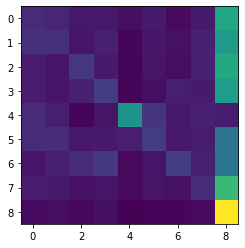

In [46]:
cm = confusion_matrix(y_val, pred)

  # # print(cm)

plt.imshow(cm)
plt.show()

In [ ]:
print(f'chance level : {1/len(models)}')

 # Same network for different training, train a classifier on one initialization and then test on a different initialization!!!

In [25]:
# del models_new

In [26]:
models_new = [torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=trained, force_reload=True,  skip_validation=True), 
              torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=trained,force_reload=True,  skip_validation=True), 
          torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=trained,force_reload=True,  skip_validation=True), 
          torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=trained,force_reload=True,  skip_validation=True),
          torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=trained,force_reload=True,  skip_validation=True), 
          torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=trained,force_reload=True,  skip_validation=True),
          # torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=trained,force_reload=True,  skip_validation=True), 
          torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=trained,force_reload=True,  skip_validation=True),
          torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl',force_reload=True,  skip_validation=True), 
          torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=trained,force_reload=True,  skip_validation=True)]



Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other t

In [27]:
prepare_models(models_new, only_tune_last_layer=only_tune_last_layer)

ResNet
ResNet
AlexNet
DenseNet
GoogLeNet
MobileNetV2
ResNet
ResNet
VisionTransformer
ResNet
2048
ResNet
2048
AlexNet
4096
DenseNet
1024
GoogLeNet
1024
MobileNetV2
1280
ResNet
2048
ResNet
2048
VisionTransformer
768


In [ ]:
# # see if you want to train the models or not
# if train_models:
#   criterion = nn.CrossEntropyLoss()

#   for model in models_new:

#     # Observe that all parameters are being optimized
#     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#     # Decay LR by a factor of 0.1 every 7 epochs
#     exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  

#     # print(
#     print(model.__class__.__name__)
#     model = train_model(model, criterion, optimizer, exp_lr_scheduler,
#                         num_epochs=epochs)

In [28]:
!unzip /content/drive/MyDrive/CIFAR10_Models_set1.zip

# loading models
for idx, model_new in enumerate(models_new):
  print(idx, model_new.__class__.__name__)
  # model = torch.load('/content/drive/MyDrive/CIFAR10_Models/model_'+str(idx)+'.pth')
  # model.load_state_dict(torch.load('/content/drive/MyDrive/CIFAR10_Models_set1/model_'+str(idx)+'.pth'))
  model_new.load_state_dict(torch.load('CIFAR10_Models_set1/model_'+str(idx)+'.pth'))
  eval_model(model_new)





Archive:  /content/drive/MyDrive/CIFAR10_Models_set1.zip
  inflating: CIFAR10_Models_set1/model_5.pth  
  inflating: CIFAR10_Models_set1/model_4.pth  
  inflating: CIFAR10_Models_set1/model_3.pth  
  inflating: CIFAR10_Models_set1/model_6.pth  
  inflating: CIFAR10_Models_set1/model_0.pth  
  inflating: CIFAR10_Models_set1/model_2.pth  
  inflating: CIFAR10_Models_set1/model_1.pth  
  inflating: CIFAR10_Models_set1/model_7.pth  
  inflating: CIFAR10_Models_set1/model_8.pth  
0 ResNet
val Acc: 0.652000
1 ResNet
val Acc: 0.663400
2 AlexNet
val Acc: 0.611900
3 DenseNet
val Acc: 0.620300
4 GoogLeNet
val Acc: 0.578600
5 MobileNetV2
val Acc: 0.593500
6 ResNet
val Acc: 0.630800
7 ResNet
val Acc: 0.640300
8 VisionTransformer
val Acc: 0.803300


In [41]:
# extract features using the new models
X_new, X_val_new = torch.empty(1,num_classes, dtype=torch.float16), torch.empty(1,num_classes,dtype=torch.float16)
y_new, y_val_new = [], []

num_datapoints = num_data

for idx, model in enumerate(models_new):
  print(model.__class__.__name__)
  train_ft, val_ft = extract_features(model, num_datapoints, case)  
  X_new = torch.vstack((X_new,train_ft))
  X_val_new = torch.vstack((X_val_new,val_ft))

  y_new.extend([idx]*train_ft.shape[0]) 
  y_val_new.extend([idx]*val_ft.shape[0]) 


X_new = X_new[1:]
X_val_new = X_val_new[1:]

y_new = torch.tensor(y_new)
y_val_new = torch.tensor(y_val_new)

idx_t = torch.randperm(X_new.shape[0])
X_new = X_new[idx_t]
y_new = y_new[idx_t]

idx_v = torch.randperm(X_val_new.shape[0])
X_val_new = X_val_new[idx_v]
y_val_new = y_val_new[idx_v]


print(X_new.shape, X_val_new.shape) #, train_ft2.shape, val_ft2.shape)
print(X_new.shape, y_val_new.shape) #, train_ft2.shape, val_ft2.shape)

ResNet
ResNet
AlexNet
DenseNet
GoogLeNet
MobileNetV2
ResNet
ResNet
VisionTransformer
torch.Size([8991, 10]) torch.Size([8991, 10])
torch.Size([8991, 10]) torch.Size([8991])


0.11233455677900123


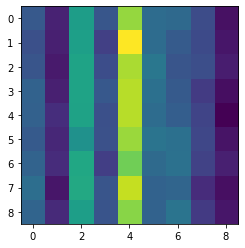

0.11411411411411411


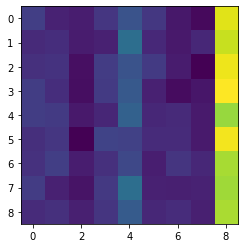

In [47]:
# test the classifiers trained on logits on new models

for m in [model_svm, model_rbf]:
  pred = m.predict(X_val_new)
  accuracy = m.score(X_val_new, y_val_new)
  cm = confusion_matrix(y_val_new, pred)

  print(accuracy)
  # print(cm)

  plt.imshow(cm)
  plt.show()


In [ ]:
# binary classifier 

# # >>> X, y = load_iris(return_X_y=True)
# clf = LogisticRegression(random_state=0).fit(X, y)
# clf.predict(X)
# # array([0, 0])
# # clf.predict_proba(X)
# # array([[9.8...e-01, 1.8...e-02, 1.4...e-08],
# #        [9.7...e-01, 2.8...e-02, ...e-08]])
# print(clf.score(X, y))
# # 0.97...

# print(clf.score(X_val, y_val))